## Python for Finance 1

#### Imports

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web # Reads stock data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import datetime as dt
import mplfinance as mpf # Matplotlib finance

#### Functions that saves stocks data to CSV

In [2]:
# Function that gets a dataframe by providing a ticker and starting date
def save_toCSV_fromYahoo(ticker, stYear, stMonth, stDay, enYear, enMonth, enDay):
    # Defines the time periods to use
    start = dt.datetime(stYear, stMonth, stMonth)
    end = dt.datetime(enYear, enMonth, enDay)
    
    # Reads data into a dataframe
    df = web.DataReader(ticker, 'yahoo', start, end)

    df.to_csv('../data/' + ticker + '.csv')
    return df

#### Function that returns a dataframe from a CSV

In [3]:
# Reads a dataframe from the CSV file, changes index to date and returns it
def get_df_fromCSV(ticker):
    try:
        df = pd.read_csv('../data/' + ticker + '.csv')
    except FileNotFoundError:
        print("File doesn't exist")
    else:
        return df

#### Add daily return to dataframe

In [7]:
# We calculate a percentage rate of return for each day to compare investments.
# Simple Rate of Return = (End Price - Beginning Price) / Beginning Price OR (EP / BP) - 1

# Shift provides the value from the previous day
# NaN is displayed because there was no previous day price for the 1st calculation

def add_dailyReturn_toDF(df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    df.to_csv('../data/' + ticker + '.csv')
    return df   

#### Returns total return over time

In [9]:
def get_return_defined_time(df, stYear, stMonth, stDay, enYear, enMonth, enDay):
    # Create string representations for the dates
    start = f"{stYear}-{stMonth}-{stDay}"
    end = f"{enYear}-{enMonth}-{enDay}"

    # Use a mask to grab data between defined dates
    mask = (df['Date'] >= start) & (df['Date'] <= end)
    # Get the mean of the column named daily return
    daily_ret = df.loc[mask]['daily_return'].mean()
    # Get the number of days between 2 dates
    df2 = df.loc[mask]
    days = df2.shape[0]
    # Return the total return between 2 dates
    return(days * daily_ret)

#### Matplotlib finance

In [11]:
# Receives a ticker and the date range for which to plot
def mplfinance_plot(ticker, chart_type, stYear, stMonth, stDay, enYear, enMonth, enDay):
    
    start = f"{stYear}-{stMonth}-{stDay}"
    end = f"{enYear}-{enMonth}-{enDay}"

    try:
        df = pd.read_csv('../data/' + ticker + '.csv')
    except FileNotFoundError:
        print("File doesn't exist")
    else:
        # Set data.index as DatetimeIndex
        df.index = pd.DatetimeIndex(df['Date'])
        # Define to only use data between provided dates
        df_sub = df.loc[start:end]
        mpf.plot(df_sub, type='candle') # A candlestick chart demonstrates the daily open, high, low and close
        mpf.plot(df_sub, type='line') # Plot price changes
        mpf.plot(df_sub, type='ohlc', mav=4) # Moving averages provide trend information (Average of previous 4 observations)

        # Define a built in style
        s = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 8})
        # Pass in the defined style to the whole canvas
        fig = mpf.figure(figsize = (12,8), style=s)
        
        ax = fig.add_subplot(2,1,2) # Candle stick chart subplot
        av = fig.add_subplot(2,1,2, sharex=ax) # Volume chart subplot

        # You can plot multiple MAVs, volume, non-trading days
        mpf.plot(df_sub, type=chart_type, mav=(3,5,7), ax=av, volume=av, show_nontrading=True)

#### Simple price plot

In [13]:
# Creates a simple price / date plot between dates
def price_plot(ticker, stYear, stMonth, stDay, enYear, enMonth, enDay):
    start = f"{stYear}-{stMonth}-{stDay}"
    end = f"{enYear}-{enMonth}-{enDay}"

    try:
        df = pd.read_csv('../data/' + ticker + '.csv')
    except FileNotFoundError:
        print("File doesn't exist")
    else:
        df.index = pd.DatetimeIndex(df['Date'])
        df_sub = df.loc[start:end]
        # Convert to Numpy array
        df_np = df_sub.to_numpy()
        # Get adjusted close data from the 5th column
        np_adj_close = df_np[:,5]
        # Get date from the 1st
        date_arr = df_np[:,1]

        # Defines area taken up by the plot
        fig = plt.figure(figsize=(12,8), dpi=100)
        axes = fig.add_axes([0,0,1,1])
        axes.plot(date_arr, np_adj_close, color='navy') # Define the plot line color as navy
        axes.xaxis.set_major_locator(plt.MaxNLocator(8)) # Set max ticks on the x axis
        axes.grid(True, color='0.6', dashes=(5, 2, 1, 2)) # Add a grid, color, dashes(5pts 1 pt dashes separated by 2pt space)
        axes.set_facecolor('#FAEBD7') # Set grid background color

#### Download multiple stocks

In [15]:
def download_multiple_stocks(stYear, stMonth, stDay, enYear, enMonth, enDay, *args):
    for x in args:
        save_toCSV_fromYahoo(x, stYear, stMonth, stDay, enYear, enMonth, enDay)

#### Merge multiple stocks in one dataframe by column name

In [18]:
def mergeDF_by_columnName(col_name, stYear, stMonth, stDay, enYear, enMonth, enDay, *tickers):
    # Will hold data for all dataframes with the same column
    mult_df = pd.DataFrame()
    
    start = f"{stYear}-{stMonth}-{stDay}"
    end = f"{enYear}-{enMonth}-{enDay}"

    for x in tickers:
        mult_df[x] = web.DataReader(x, 'yahoo', start, end)[col_name]
    return mult_df

#### Get changing value of investment using multiple stocks

In [19]:
def plot_return_mult_stocks(investment, stock_df):
    (stock_df / stock_df.iloc[0] * investment).plot(figsize=(15,6))

#### Get standard deviation for multiple stocks

Risk is a measure of the variability of return. Variance and Standard Deviation allow us to quantify risk.

Variance is a measure of how spread out a data set is. It is calculated as the average squared deviation of each number from the mean of a data set.n It equals the sum of the squares of the difference between each data point and the mean divided by the number of data points minus 1.

$s^2 = \frac{\sum (x - \hat{x})^2}{N-1}$

Example : If we have 3 annual returns of 23%, -8% and 15%. The mean return is 10%.

- $(23 - 10)^2 = 169$
- $(-8 -10)^2 = 324$
- $(15 - 10)^2 = 25$
- $169 + 324 + 25 = 518 / (3-1) = 259 = 2.59$

Standard deviation is a measure of the amount of variation within a set of values. A low standard deviation indicates that the values tend to be close to the mean. A high standard deviation means values are more spread out. To get the Standard Deviation find the square root of the variance.

$\sqrt{s^2} = \sqrt{2.59} = 1.609$

In [25]:
# Receives the dataframe with the Adj Close data along with the stock ticker
# Returns the mean and standard deviation associated with the ticker
def get_stock_mean_sd(stock_df, ticker):
    return stock_df[ticker].mean(), stock_df[ticker].std()

In [26]:
# Receives the dataframe with the stock ticker as the column name and
# the Adj Close values as the column data and returns the mean and 
# standard deviation
def get_multStock_mean_sd(stock_df):
    for stock in stock_df:
        mean, sd = get_stock_mean_sd(stock_df, stock)
        cov = sd / mean
        print("Stock: {:4} Mean: {:7.2f} Standard Deviation: {:2.2f}".format(stock, mean, sd))
        print("Coefficient of Variation: {}\n".format(cov))

---

Test functions

In [5]:
save_toCSV_fromYahoo('AMZN', 2020, 1, 1, 2021, 1, 1)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,1898.010010,1864.150024,1875.000000,1898.010010,4029000,1898.010010
2020-01-03,1886.199951,1864.500000,1864.500000,1874.969971,3764400,1874.969971
2020-01-06,1903.689941,1860.000000,1860.000000,1902.880005,4061800,1902.880005
2020-01-07,1913.890015,1892.040039,1904.500000,1906.859985,4044900,1906.859985
2020-01-08,1911.000000,1886.439941,1898.040039,1891.969971,3508000,1891.969971
...,...,...,...,...,...,...
2020-12-24,3202.000000,3169.000000,3193.899902,3172.689941,1451900,3172.689941
2020-12-28,3304.000000,3172.689941,3194.000000,3283.959961,5686800,3283.959961
2020-12-29,3350.649902,3281.219971,3309.939941,3322.000000,4872900,3322.000000


In [6]:
AMZN = get_df_fromCSV('AMZN')
AMZN.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2020-01-02,1898.010010,1864.150024,1875.000000,1898.010010,4029000,1898.010010
1,2020-01-03,1886.199951,1864.500000,1864.500000,1874.969971,3764400,1874.969971
2,2020-01-06,1903.689941,1860.000000,1860.000000,1902.880005,4061800,1902.880005
3,2020-01-07,1913.890015,1892.040039,1904.500000,1906.859985,4044900,1906.859985
4,2020-01-08,1911.000000,1886.439941,1898.040039,1891.969971,3508000,1891.969971


In [8]:
add_dailyReturn_toDF(AMZN, 'AMZN')
AMZN.head()

,Date,High,Low,Open,Close,Volume,Adj Close,daily_return
0,2020-01-02,1898.010010,1864.150024,1875.000000,1898.010010,4029000,1898.010010,NaN
1,2020-01-03,1886.199951,1864.500000,1864.500000,1874.969971,3764400,1874.969971,-0.012139
2,2020-01-06,1903.689941,1860.000000,1860.000000,1902.880005,4061800,1902.880005,0.014886
3,2020-01-07,1913.890015,1892.040039,1904.500000,1906.859985,4044900,1906.859985,0.002092
4,2020-01-08,1911.000000,1886.439941,1898.040039,1891.969971,3508000,1891.969971,-0.007809


In [10]:
tot_return = get_return_defined_time(AMZN, 2020, 1, 1, 2021, 1, 1)
print("Total Return: ", tot_return)

Total Return:  0.04777517423943911


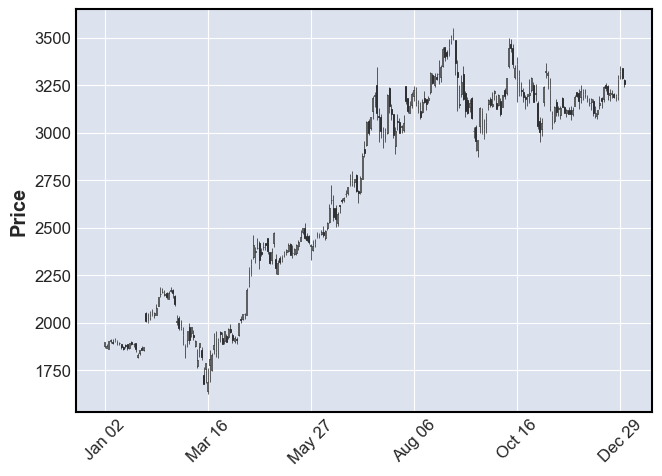

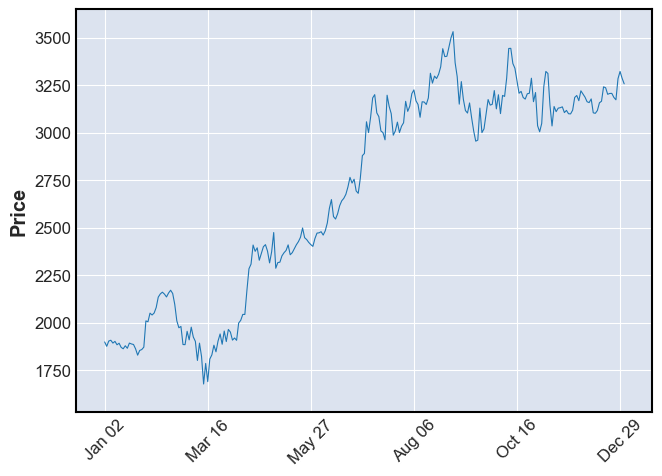

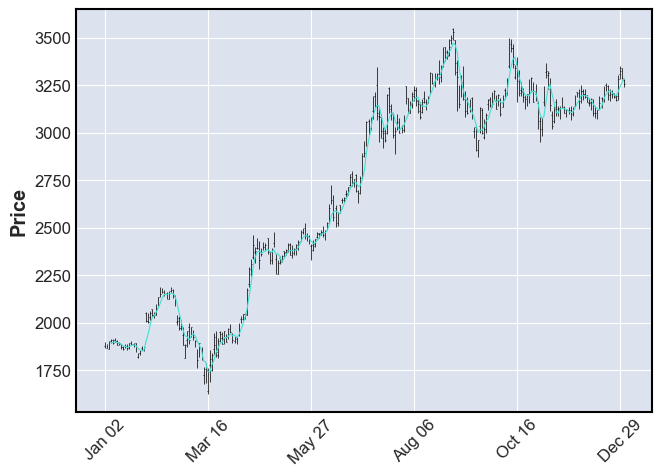

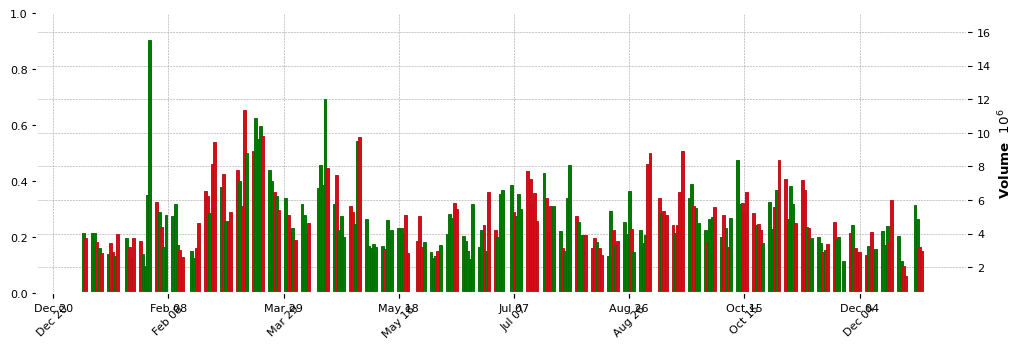

In [12]:
mplfinance_plot('AMZN', 'ohlc', 2020, 1, 1, 2021, 1, 1)

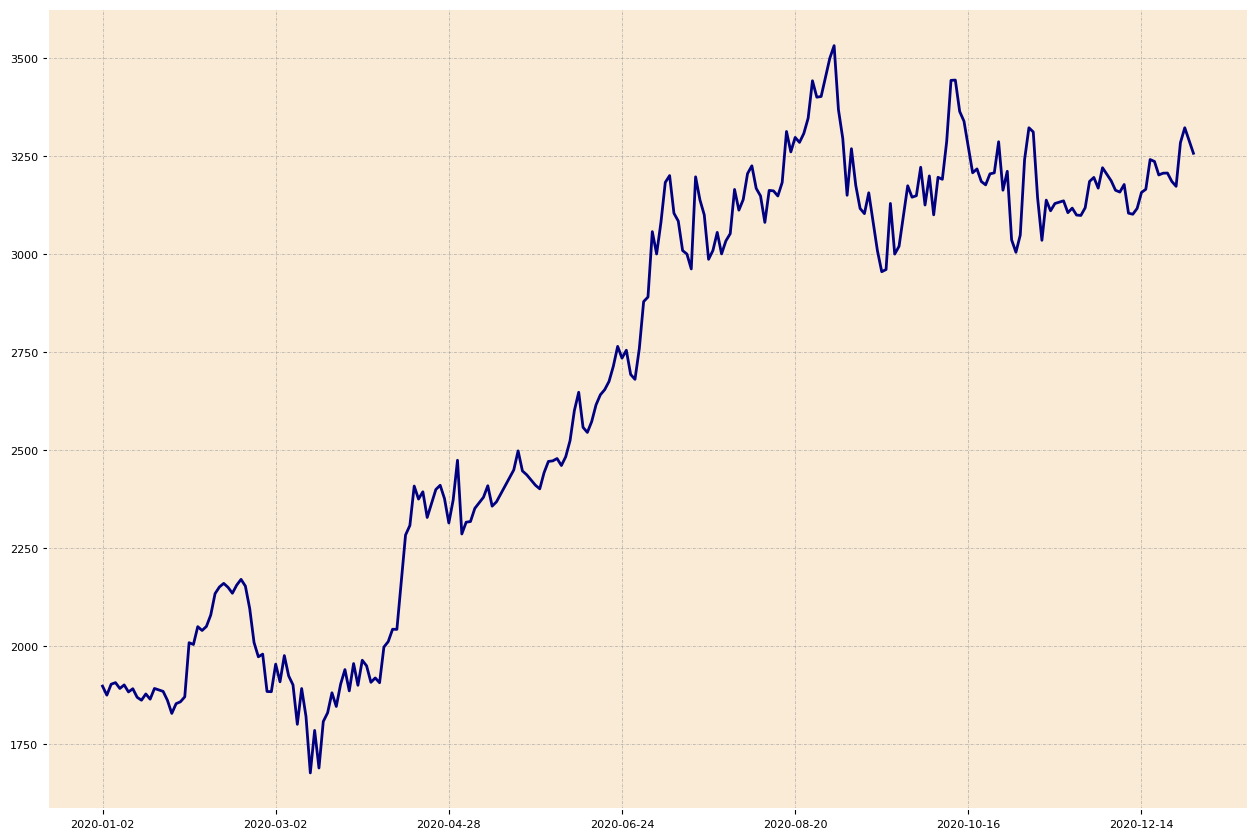

In [14]:
price_plot('AMZN', 2020, 1, 1, 2021, 1, 1)

In [16]:
tickers = ['FB', 'AAPL', 'NFLX', 'GOOG']
download_multiple_stocks(2020, 1, 1, 2021, 1, 1, *tickers)

In [20]:
tickers = ['AMZN', 'FB', 'AAPL', 'NFLX', 'GOOG']
mult_df = mergeDF_by_columnName('Adj Close', 2020, 1, 1, 2021, 1, 1, *tickers)

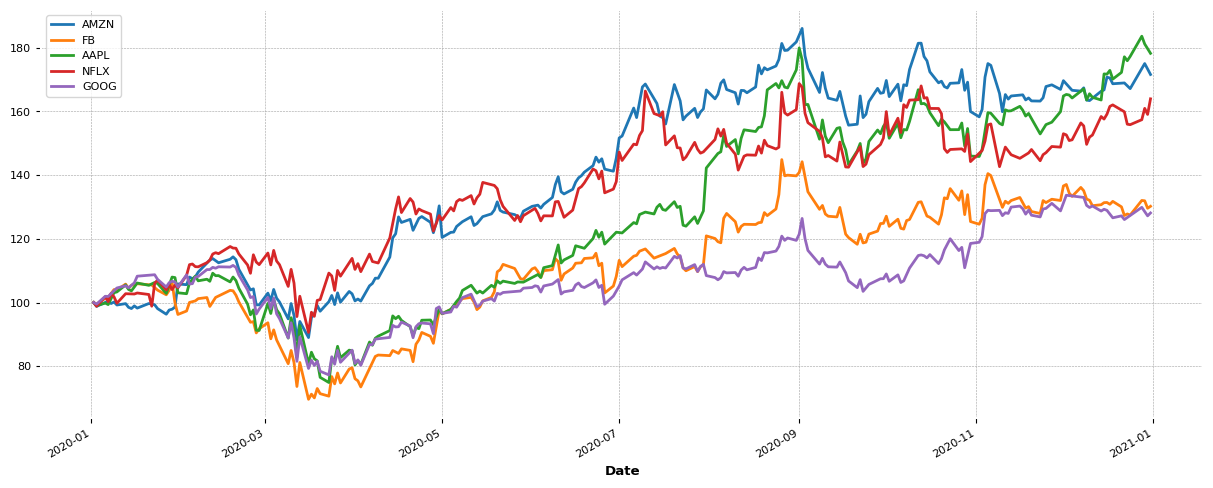

In [21]:
plot_return_mult_stocks(100, mult_df)

In [27]:
get_multStock_mean_sd(mult_df)
mult_df

Stock: AMZN Mean: 2680.86 Standard Deviation: 545.76
Coefficient of Variation: 0.20357722570815504

Stock: FB   Mean:  234.55 Standard Deviation: 38.57
Coefficient of Variation: 0.1644238149761194

Stock: AAPL Mean:   94.34 Standard Deviation: 21.79
Coefficient of Variation: 0.2309901558993235

Stock: NFLX Mean:  446.83 Standard Deviation: 65.61
Coefficient of Variation: 0.14684116488739776

Stock: GOOG Mean: 1481.40 Standard Deviation: 175.97
Coefficient of Variation: 0.11878452933446867



,AMZN,FB,AAPL,NFLX,GOOG
Date,,,,,
2020-01-02,1898.010010,209.779999,73.894325,329.809998,1367.369995
2020-01-03,1874.969971,208.669998,73.175919,325.899994,1360.660034
2020-01-06,1902.880005,212.600006,73.759003,335.829987,1394.209961
2020-01-07,1906.859985,213.059998,73.412109,330.750000,1393.339966
2020-01-08,1891.969971,215.220001,74.593048,339.260010,1404.319946
...,...,...,...,...,...
2020-12-24,3172.689941,267.399994,130.994507,513.969971,1738.849976
2020-12-28,3283.959961,277.000000,135.679642,519.119995,1776.089966
2020-12-29,3322.000000,276.779999,133.873077,530.869995,1758.719971
